In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline, interp1d, make_interp_spline, make_lsq_spline, splrep, splev
from src.plotting.plot_utils import import_input_data
import yaml
import warnings
from src.weibull_fitting import weibull3_from_digitized, weibull3_params_from_digitized
from lifelines import WeibullFitter
warnings.filterwarnings("ignore")

with open('config.yaml', 'r') as f:
    CONFIG = yaml.safe_load(f)

COMBO_SEED_SHEET = CONFIG['metadata_sheet']['combo_seed']
COMBO_DATA_DIR = CONFIG['dir']['combo_data']
RAW_COMBO_DATA_DIR = CONFIG['dir']['raw_combo_data']
PFS_PRED_DIR = CONFIG['dir']['PFS_prediction']
OUTDIR = f"{CONFIG['dir']['figures']}/splines"
Path(OUTDIR).mkdir(exist_ok=True, parents=True)


In [2]:
df = import_input_data()

# Check weibull fit

In [3]:
from src.weibull_fitting import *

test = generate_weibull(200, 20, 3, 1, 10, gauss_noise=True)
wbf = weibull3_from_digitized(test, 200, 20)
print(weibull3_params_from_digitized(test, 20))



   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 3.383254E+01    MAXCV = 0.000000E+00
   X = 8.069398E-01   3.250193E+00   5.015996E+00
(0.8069398213771868, 3.2501926534716126, 5.015995934488562)


19 Lung_Atezolizumab-PaclitaxelProteinBound+Carboplatin_West2019_PFS

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 1.116244E+03    MAXCV = 0.000000E+00
   X = 1.247622E+00   9.567337E+00   7.565567E+00


KeyboardInterrupt: 

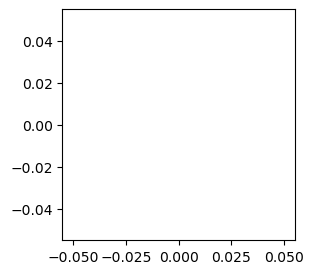

In [3]:
# calculate likelihood
tmp = df
tstep = 0.25
#for i in range(tmp.shape[0]):
for i in [19]:
    name_a = tmp.at[i, 'Experimental']
    name_b = tmp.at[i, 'Control']
    name_ab = tmp.at[i, 'Combination']
    n_combo = tmp.at[i, 'N_combination']

    # import prediction
    independent = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_ind.csv').dropna()
    independent = independent[independent['Time'] < 24]
    additive = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_add.csv').dropna()
    models = [independent, additive]
    print(i, name_ab)
    for k in range(len(models)):
        # create spline
        model = models[k]
        tmax = model['Time'].max() - tstep
        #wbf = weibull_params_from_digitized(model, tmax)
        wbf = weibull3_from_digitized(model, 500, tmax)
        #print(wbf)
        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(x='Time', y='Survival', data=model, label='model')
        sns.lineplot(x='Time', y='Survival', data=wbf, label='weibull')


$$d/dt((1 - c) (1 - e^(-(t/b)^a))) = -(a (c - 1) e^(-(t/b)^a) (t/b)^a)/t$$

In [4]:
def weibull_pdf(t, a, b, c):
    c = c/100
    return (a * (1-c)/t) * ((t/b)**(a-1)) * np.exp(-((t/b)**a))

In [5]:
def weibull_survival(t, a, b, c):
    c = c/100
    return c + (1-c) * np.exp(-((t/b)**a))

In [6]:
def interpolate(df, x='Time', y='Survival', kind='zero'):
    return interp1d(df[x], df[y], kind=kind, fill_value='extrapolate')


def create_ipd(df: pd.DataFrame, n=500) -> pd.DataFrame:
    # FIXME works fine as is, but can be problematic if you don't preprocess the additiivty
    # and HSA predictions that the survival curves go down to zero (which is misleading)
    """Creates individual patient data (IPD) for a given survival curve.
    The survival curve is broken into n equal survival intervals. All events are considered
    as failed before the end of follow-up. All events after follow-up are considered
    censored.

    Args:
        df (pd.DataFrame): survival data points
        n (int, optional): number of patients to generate. Defaults to 500.

    Returns:
        pd.DataFrame: individual patient data
    """
    interp = interpolate(df, x='Survival', y='Time')
    # censoring due to loss of follow-up at the tail
    min_surv = np.round(np.ceil(df['Survival'].min())/100, 2)
    events = np.hstack((np.repeat(0, round(min_surv * n)),
                        np.repeat(1, round((1 - min_surv) * n))))
    if len(events) > n:
        events = events[len(events) - n:]

    t = interp(np.linspace(0, 100, n))
    return pd.DataFrame({'Time': t, 'Event': events})


In [7]:
lik_df = pd.DataFrame(index=df.index, columns=['Name', 'HSA_NLL', 'Add_NLL'])

### Using Lifelines WeibullFitter

0 Breast_Abemaciclib-Fulvestrant_Sledge2017_PFS
1 Breast_Abemaciclib-LetrozoleOrAnastrozole_Johnston2019_PFS
2 Breast_Capecitabine-Docetaxel_OShaughnessy2002_PFS
3 Breast_Everolimus-Exemestane_Baselga2012_PFS
4 Breast_Ixabepilone-Capecitabine_Thomas2007_PFS
5 Breast_Lapatinib-Capecitabine_Kaufman2008_PFS
6 Breast_Palbociclib-Fulvestrant_Cristofanilli2016_PFS
7 Breast_Palbociclib-Letrozole_Finn2016_PFS
8 Breast_Pembrolizumab-Chemotherapy_Cortes2020_PFS_CPS10higher
9 Breast_Trastuzumab-Chemotherapy_Slamon2001_PFS
10 Cervical_Bevacizumab-Paclitaxel+CisplatinOrTopotecan_Tewari2014_PFS


Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f9a10e7c560>
Traceback (most recent call last):
  File "/Users/haeunhwangbo/mambaforge/envs/surv/lib/python3.7/weakref.py", line 51, in _cb
    def _cb(arg):
KeyboardInterrupt


11 Colorectal_Bevacizumab-Fluorouracil+Leucovorin+Oxaliplatin_Giantonio2007_PFS
12 Colorectal_Cetuximab-FOLFIRI_VanCutsem2015_PFS_RAS-WT
13 Colorectal_Irinotecan-Cetuximab_Cunningham2004_PFS
14 Colorectal_ZivAflibercept-FOLFIRI_VanCutsem2012_PFS
15 Gastric_Ramucirumab-Paclitaxel_Wilke2014_PFS
16 HeadNeck_Cetuximab-Platinum+Fluorouracil_Vermorken2008_PFS
17 Leukemia_Obinutuzumab-Chlorambucil_Goede2014_PFS
18 Lung_Atezolizumab-Bevacizumab+Paclitaxel+Carboplatin_Socinski2018_PFS
19 Lung_Atezolizumab-PaclitaxelProteinBound+Carboplatin_West2019_PFS
20 Lung_Atezolizumab-Carboplatin+Etoposide_Horn2018_PFS
21 Lung_Gemcitabine-Cisplatin_Sandler2000_PFS
22 Melanoma_Nivolumab-Ipilimumab_Larkin2019_PFS
23 Melanoma_Trametinib-Dabrafenib_Long2017_PFS
24 Mesothelioma_PemetrexedDisodium-Cisplatin_Vogelzang2003_TTP
25 Myeloma_Carfilzomib-Lenalidomide+Dexamethasone_Steward2015_PFS
26 Myeloma_Daratumumab-Bortezomib+Dexamethasone_Palumbo2016_PFS
27 Myeloma_Daratumumab-Carfilzomib+Dexamethasone_Dimopoulos2

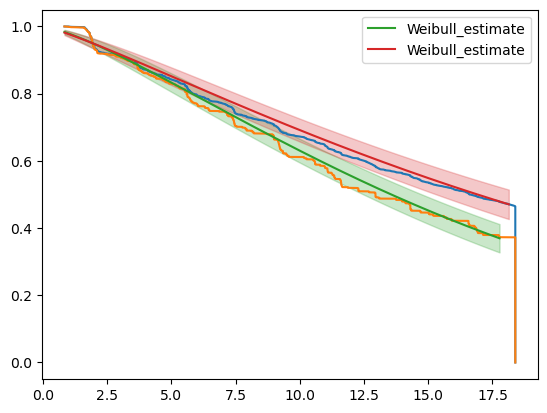

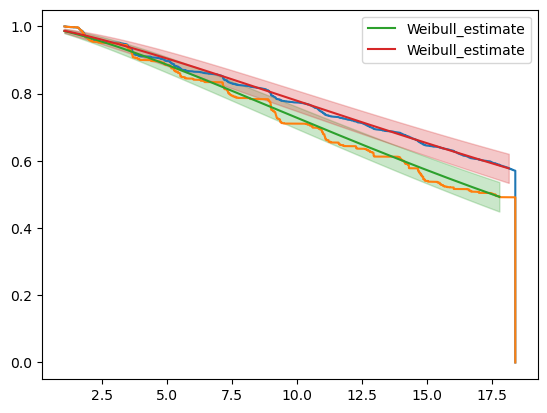

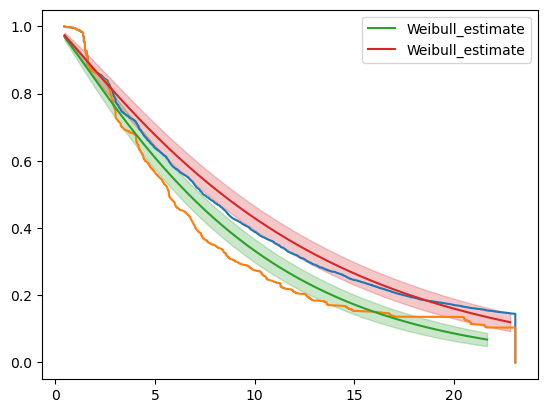

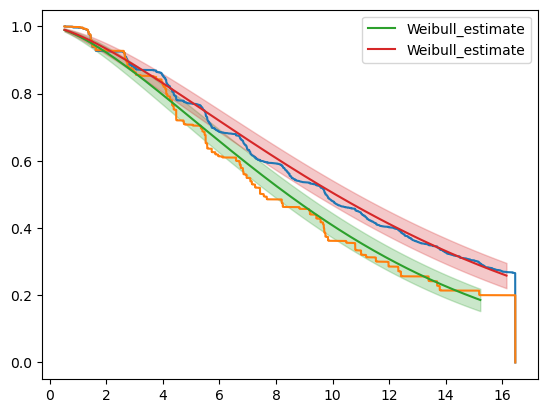

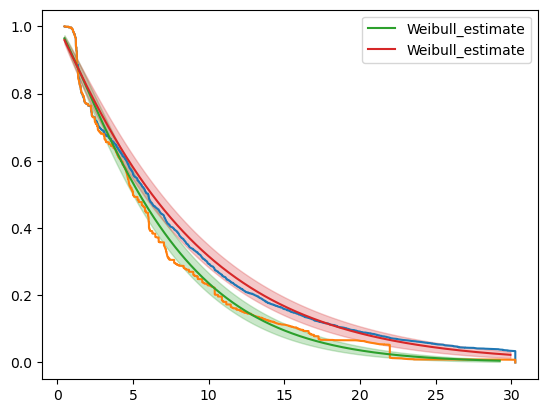

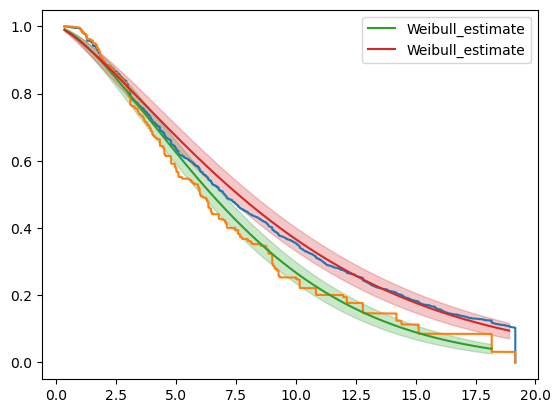

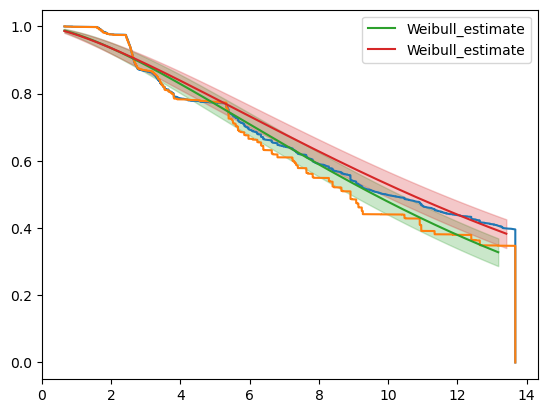

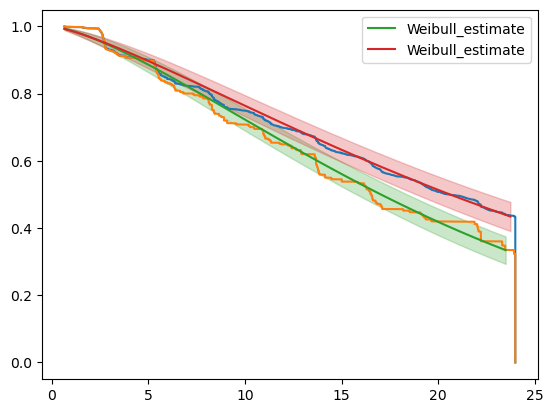

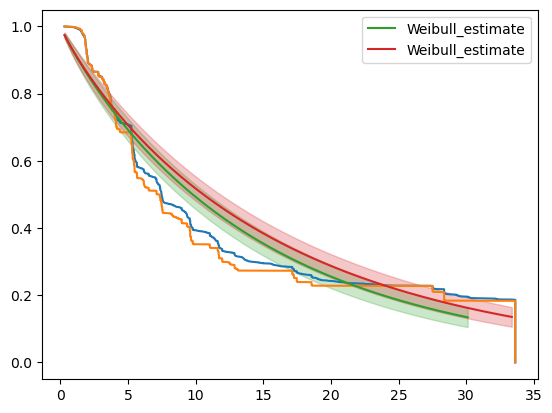

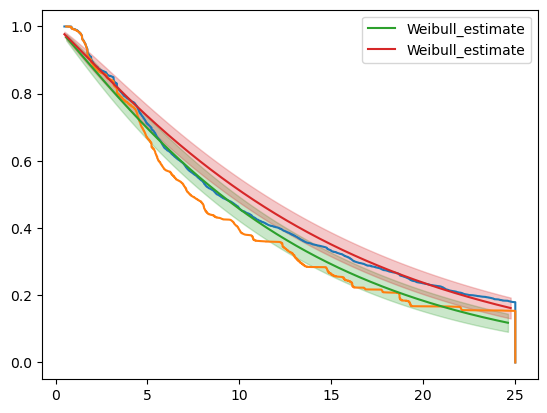

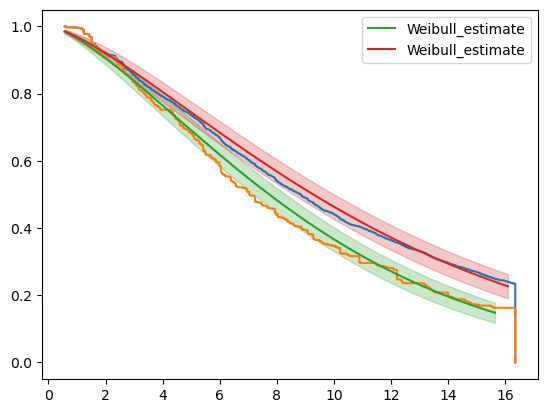

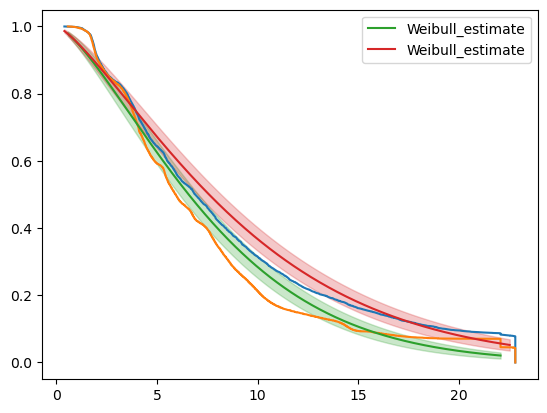

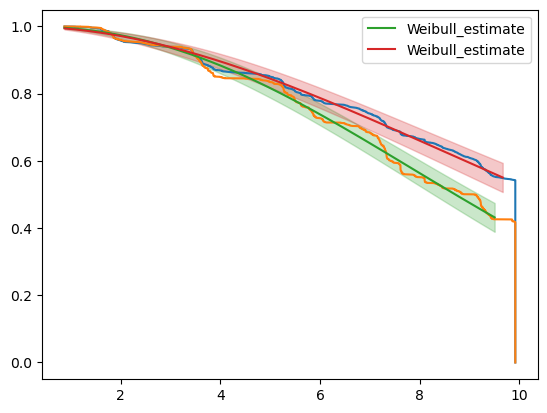

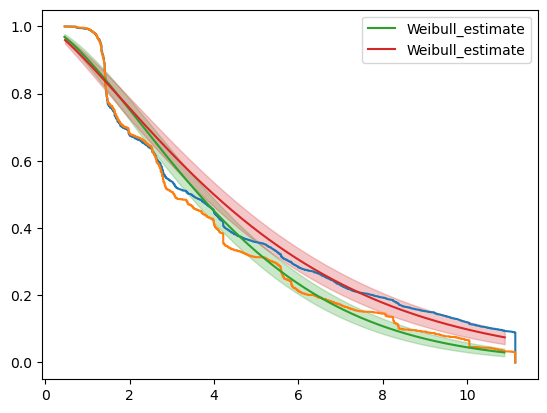

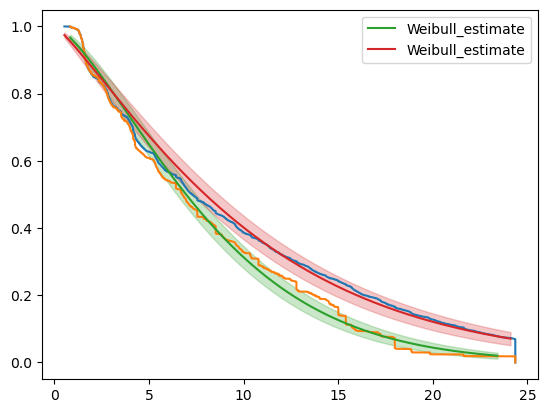

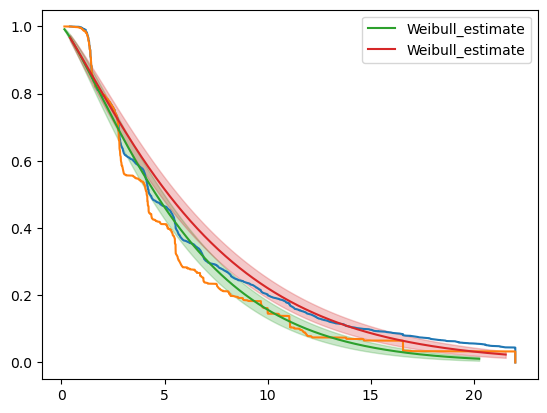

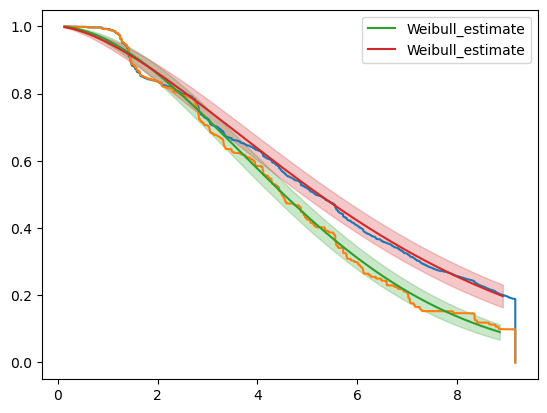

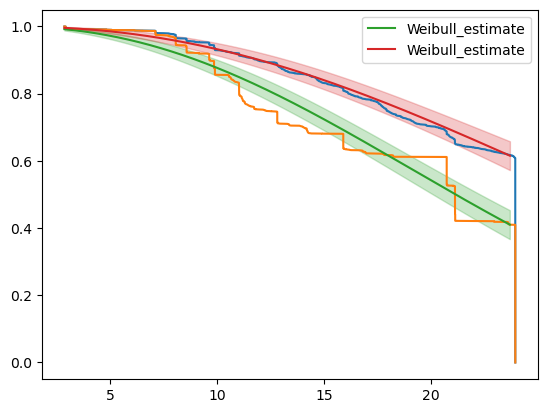

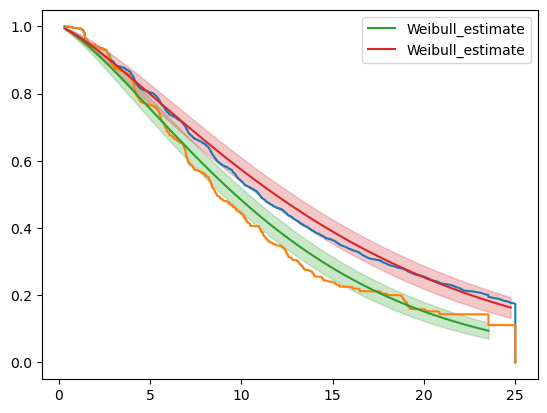

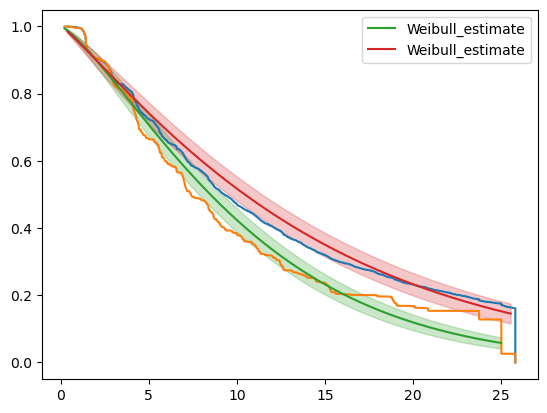

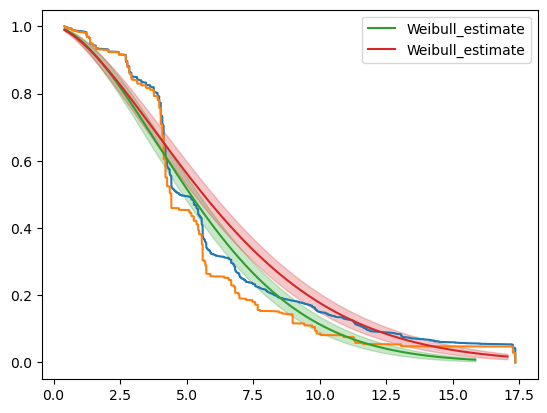

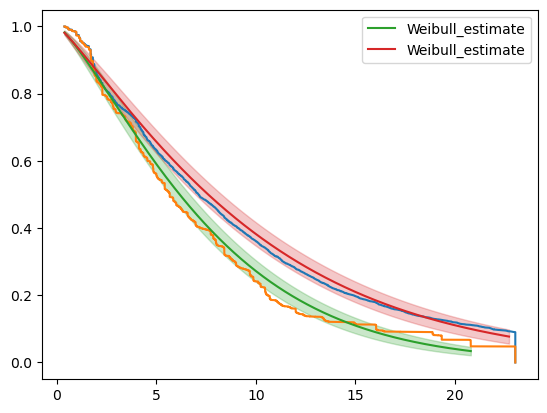

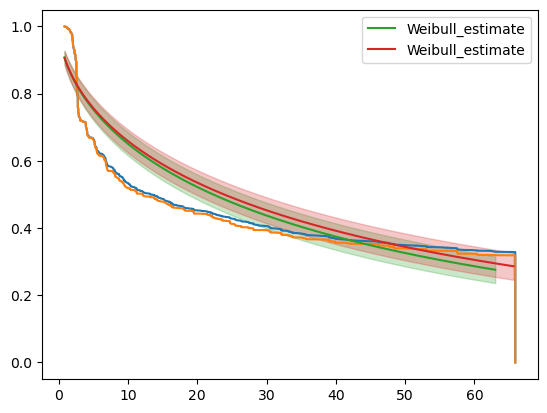

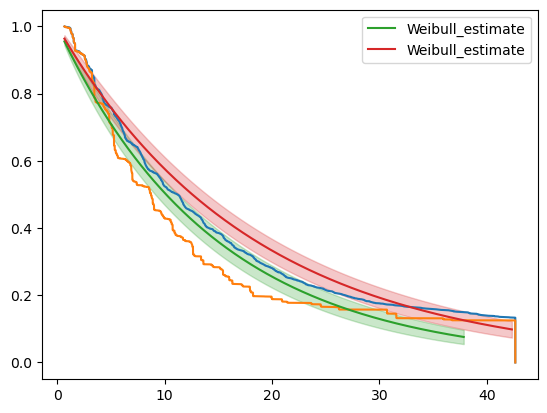

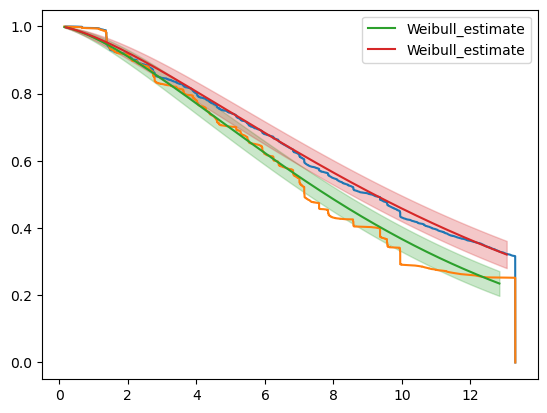

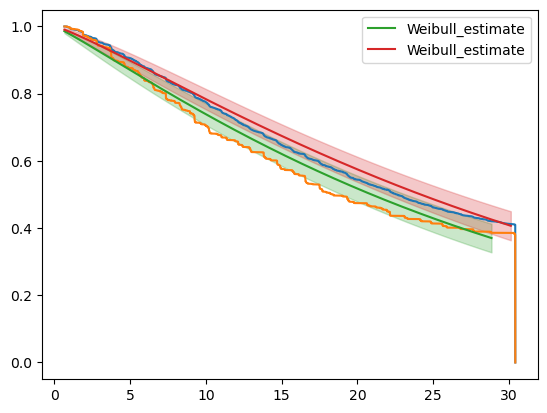

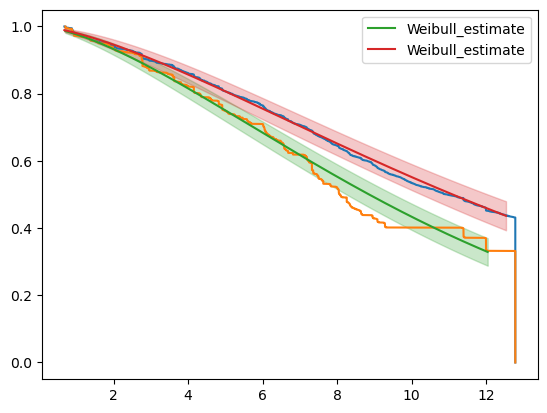

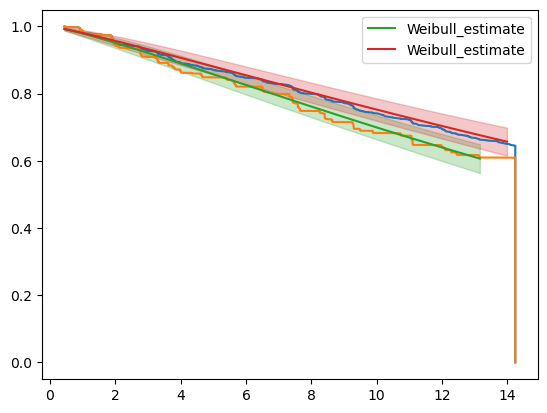

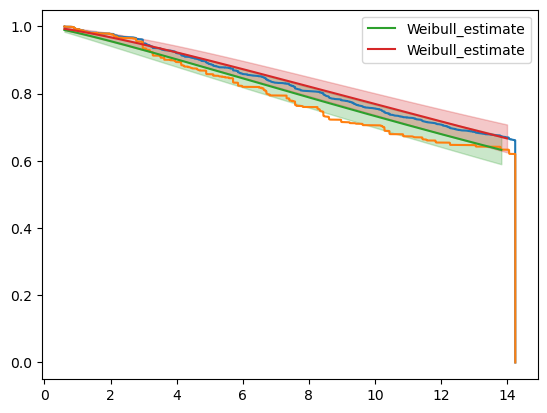

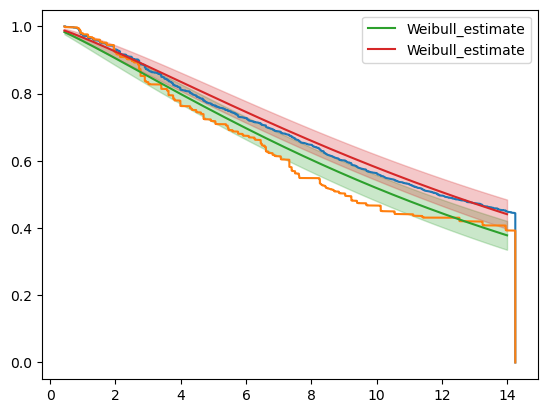

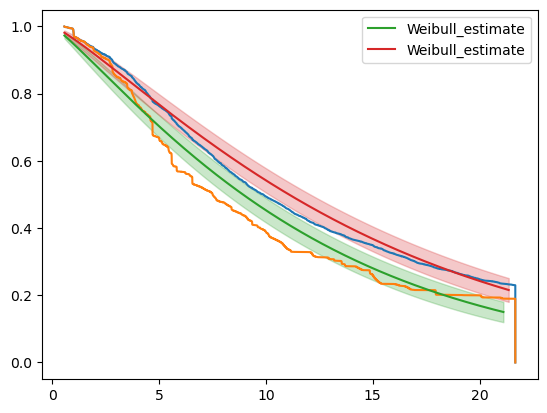

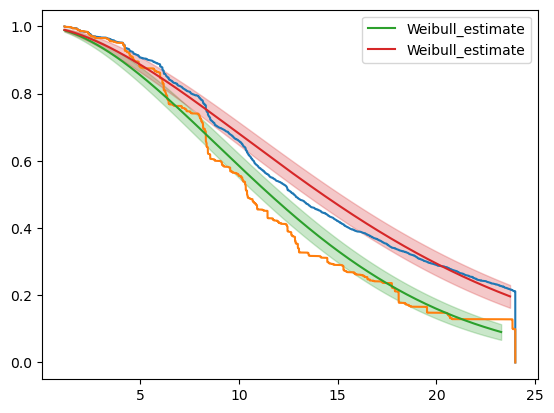

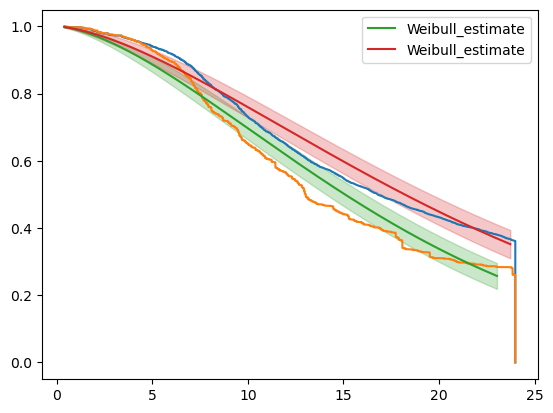

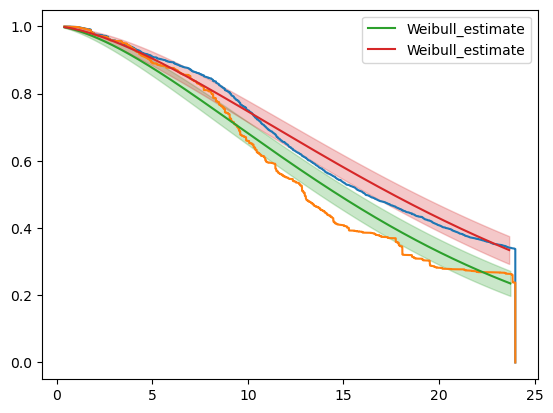

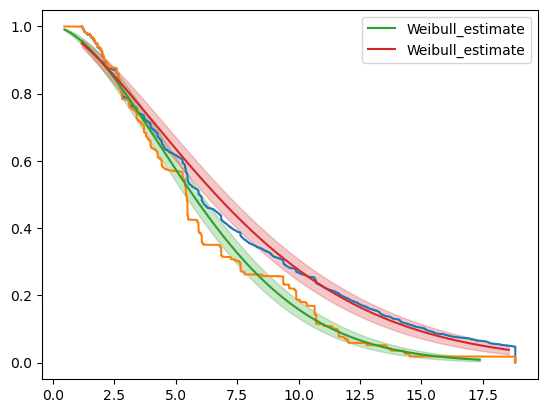

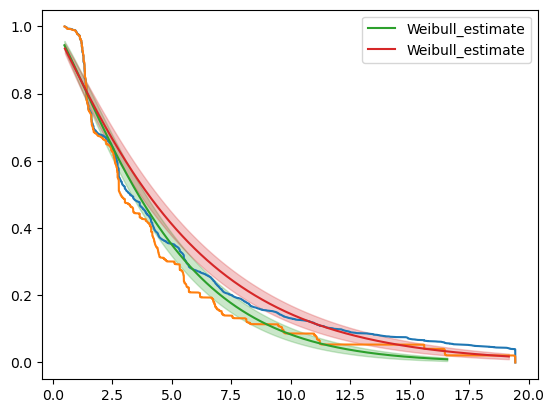

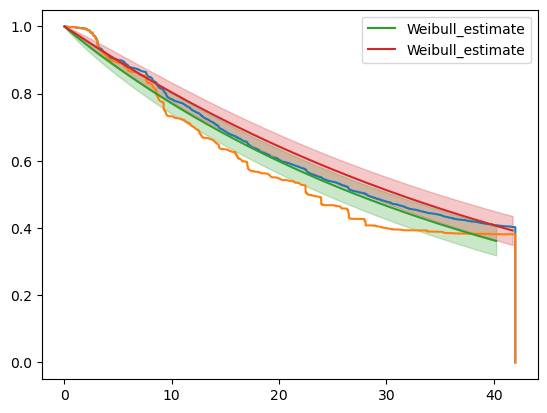

In [33]:
# using lifelines weibull fitter
# # calculate likelihood
tmp = df
tstep = 0.25
for i in range(tmp.shape[0]):
#for i in [22]:
    name_a = tmp.at[i, 'Experimental']
    name_b = tmp.at[i, 'Control']
    name_ab = tmp.at[i, 'Combination']
    n_combo = tmp.at[i, 'N_combination']
    lik_df.at[i, 'Name'] = name_ab
    #print(i, n_combo)
    # observed data
    df_ab = pd.read_csv(f'{COMBO_DATA_DIR}/{name_ab}.clean.csv').dropna()
    try:
        ipd_ab = pd.read_csv(f'{RAW_COMBO_DATA_DIR}/{name_ab}_indiv.csv')
        #print("used IPD")
    except FileNotFoundError:
        ipd_ab = create_ipd(df_ab, n=n_combo)
    

    # import prediction
    independent = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_ind.csv').dropna()
    additive = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_add.csv').dropna()
    models = [independent, additive]
    print(i, name_ab)

    t = np.linspace(0, tmax, 100)
    fig, ax = plt.subplots()
    ax.plot(additive['Time'], additive['Survival']/100)
    ax.plot(independent['Time'], independent['Survival']/100)
    for k in range(len(models)):
        model = models[k]
        tmax = model['Time'].max() - tstep
        ipd_model = create_ipd(model[model['Time'] < tmax])
        wbf = WeibullFitter()
        wbf.fit(ipd_model['Time'], ipd_model['Event'])
        wbf.plot_survival_function(ax=ax)
        t_event = ipd_ab[ipd_ab['Event'] == 1]['Time'].values
        t_censor = ipd_ab[ipd_ab['Event'] == 0]['Time'].values
        l_event = wbf.density_at_times(t_event).values
        l_censor = wbf.survival_function_at_times(t_censor).values
        l_all = np.hstack((l_event, l_censor))
        #plt.plot(t_event, l_event, label=k)
        #plt.plot(t_censor, l_censor, label=k)
        neg_log_lik = np.round(np.sum(-np.log(l_all)), 3)
        if k == 0:
            lik_df.at[i, 'HSA_NLL'] = neg_log_lik
        elif k == 1:
            lik_df.at[i, 'Add_NLL'] = neg_log_lik

        #plt.vlines(t_event, ymin=0, ymax=100)
        #plt.vlines(t_censor, ymin=0, ymax=100)

plt.legend()

### Using custom weibull fitter

In [10]:
tmax_dict = {4: 20, 5: 15, 8: 25, 11:20, 13: 9, 
             14: 15, 15: 15, 17:15, 19: 20, 20: 15, 
             21: 15, 22: 40, 23: 30, 34:15, 35:15}

In [13]:
type(tmax_dict.get(36))

NoneType

0 Breast_Abemaciclib-Fulvestrant_Sledge2017_PFS
1 Breast_Abemaciclib-LetrozoleOrAnastrozole_Johnston2019_PFS
2 Breast_Capecitabine-Docetaxel_OShaughnessy2002_PFS
3 Breast_Everolimus-Exemestane_Baselga2012_PFS
4 Breast_Ixabepilone-Capecitabine_Thomas2007_PFS
5 Breast_Lapatinib-Capecitabine_Kaufman2008_PFS
6 Breast_Palbociclib-Fulvestrant_Cristofanilli2016_PFS
7 Breast_Palbociclib-Letrozole_Finn2016_PFS
8 Breast_Pembrolizumab-Chemotherapy_Cortes2020_PFS_CPS10higher
9 Breast_Trastuzumab-Chemotherapy_Slamon2001_PFS
10 Cervical_Bevacizumab-Paclitaxel+CisplatinOrTopotecan_Tewari2014_PFS
11 Colorectal_Bevacizumab-Fluorouracil+Leucovorin+Oxaliplatin_Giantonio2007_PFS
12 Colorectal_Cetuximab-FOLFIRI_VanCutsem2015_PFS_RAS-WT
13 Colorectal_Irinotecan-Cetuximab_Cunningham2004_PFS
14 Colorectal_ZivAflibercept-FOLFIRI_VanCutsem2012_PFS
15 Gastric_Ramucirumab-Paclitaxel_Wilke2014_PFS
16 HeadNeck_Cetuximab-Platinum+Fluorouracil_Vermorken2008_PFS
17 Leukemia_Obinutuzumab-Chlorambucil_Goede2014_PFS
18 L

No handles with labels found to put in legend.


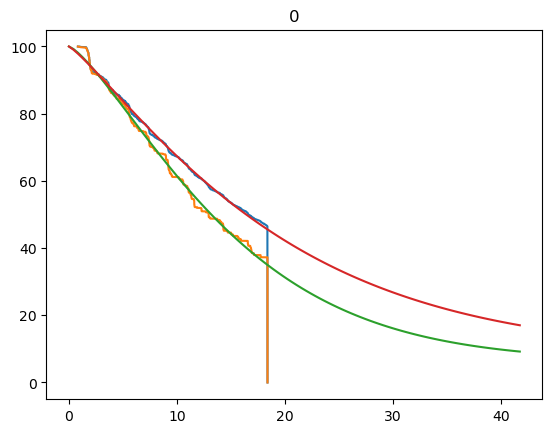

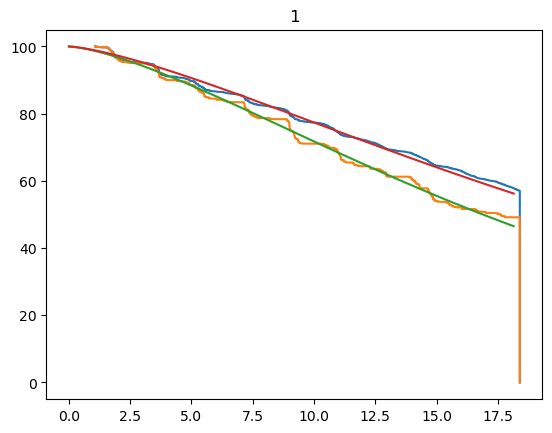

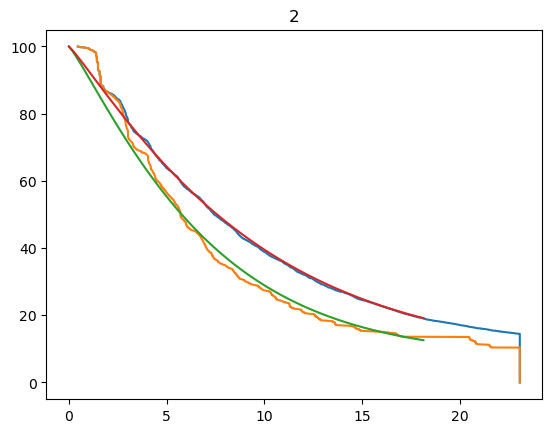

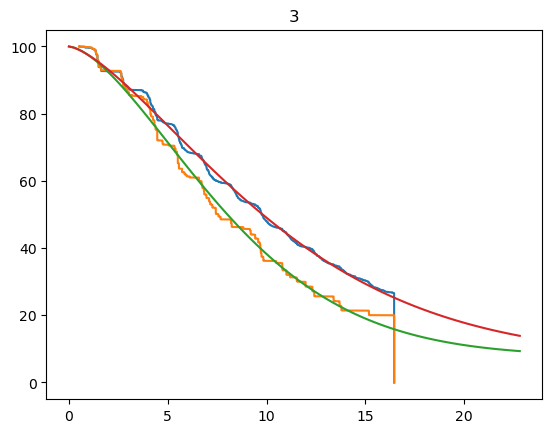

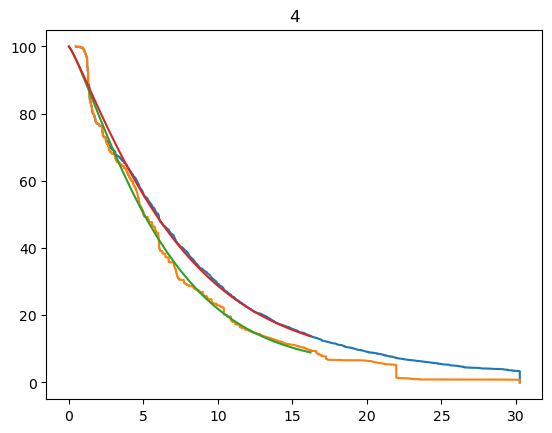

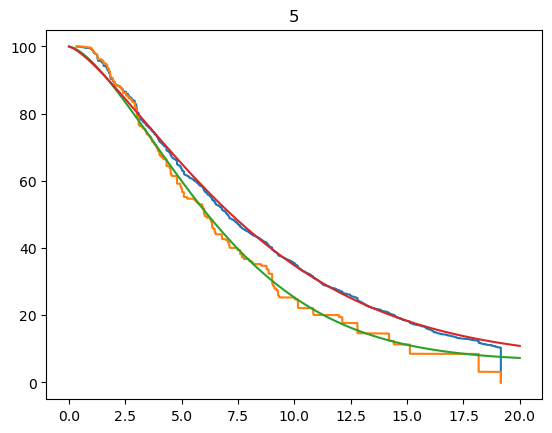

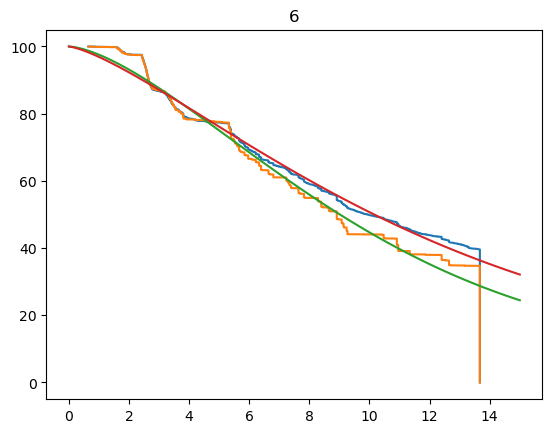

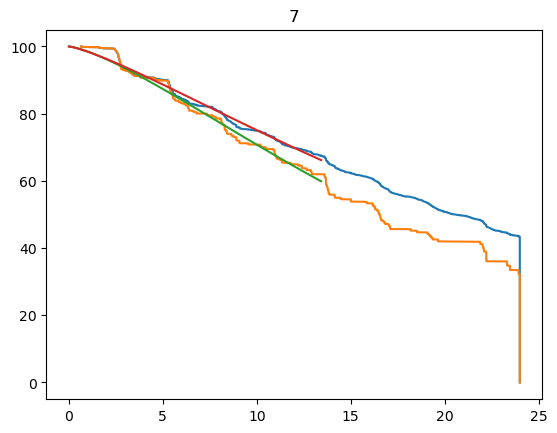

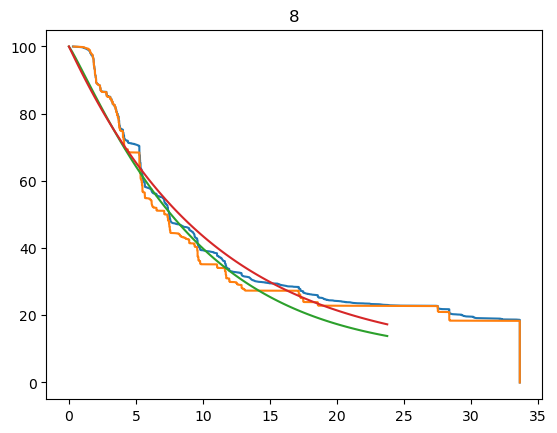

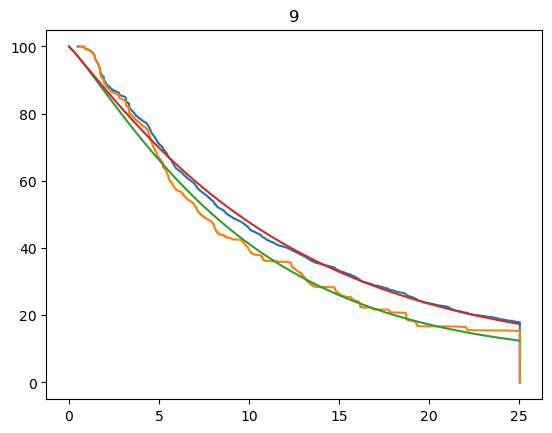

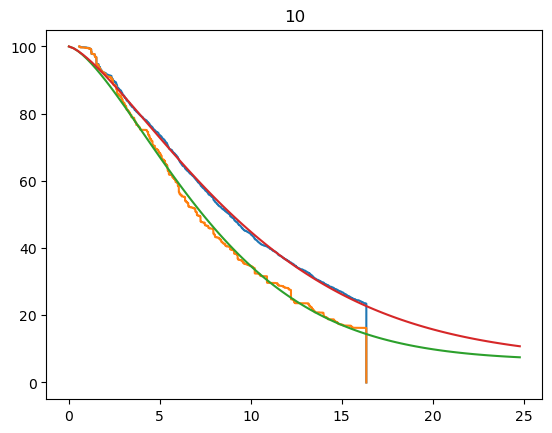

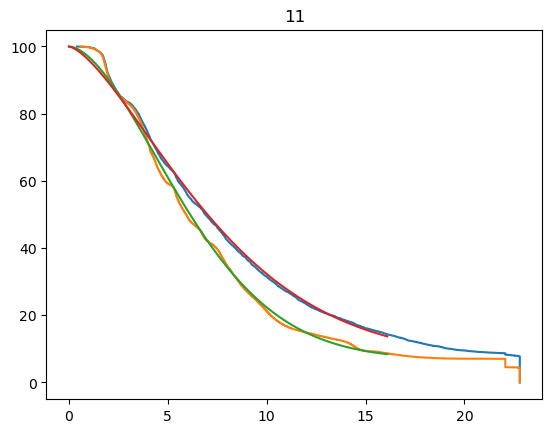

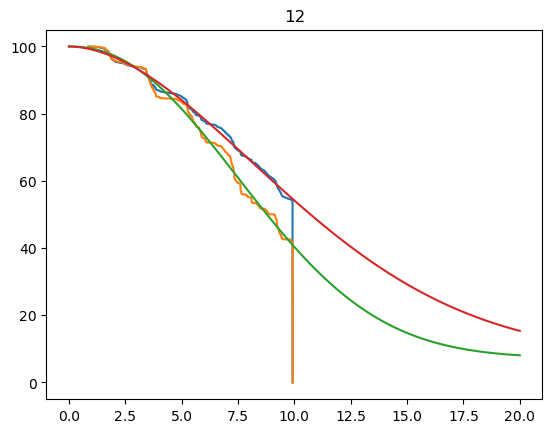

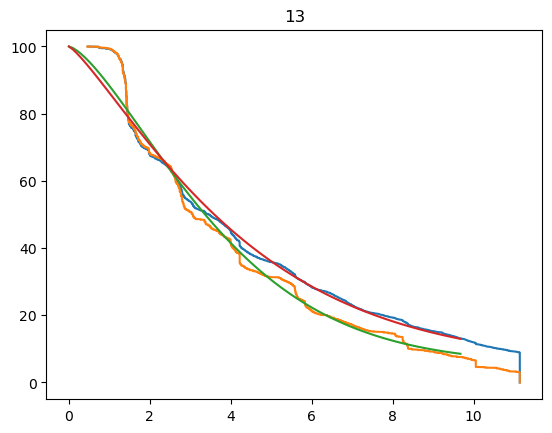

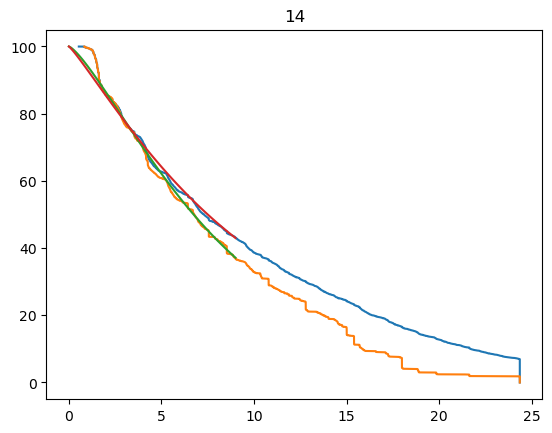

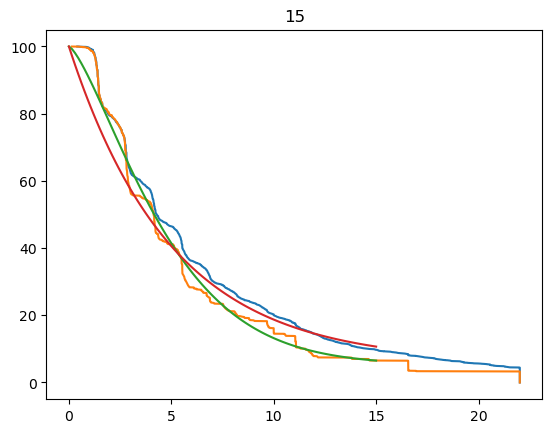

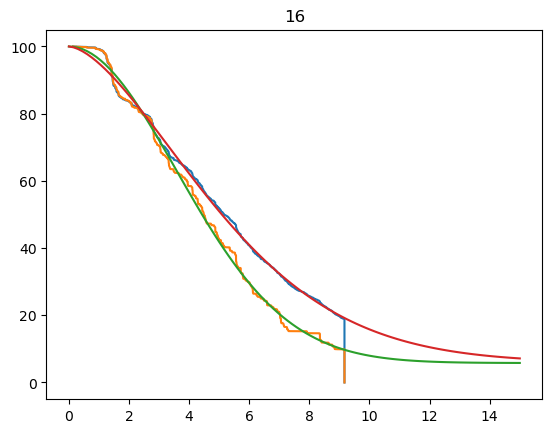

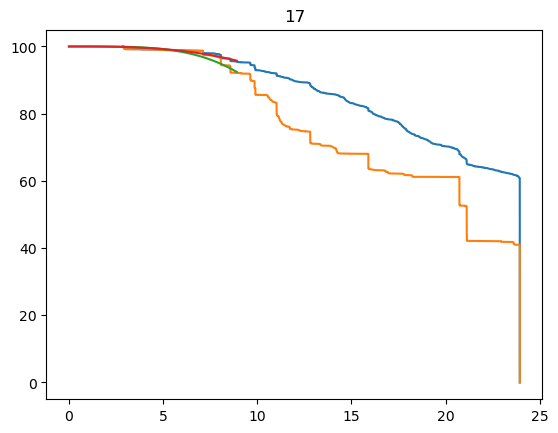

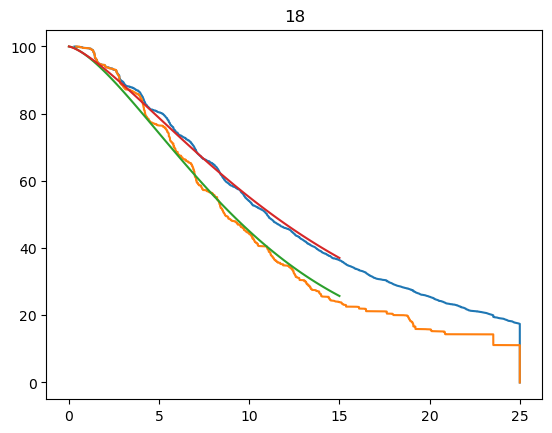

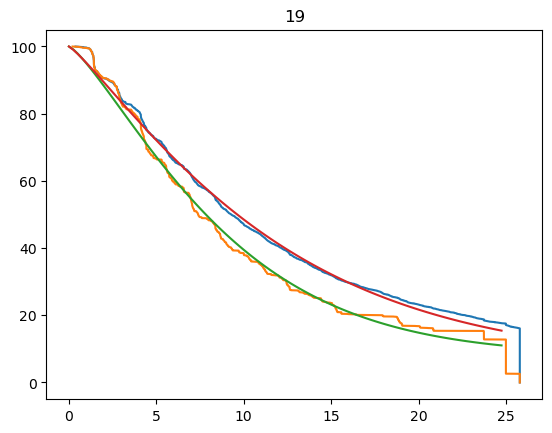

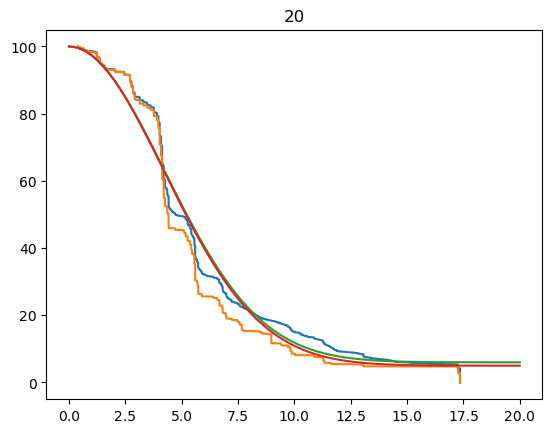

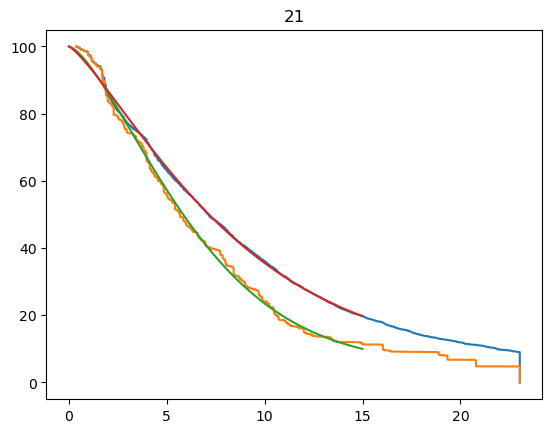

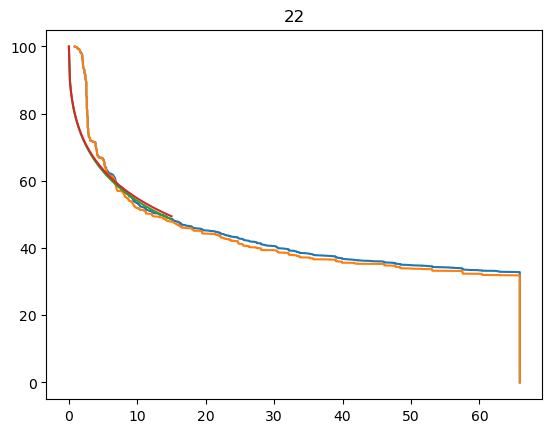

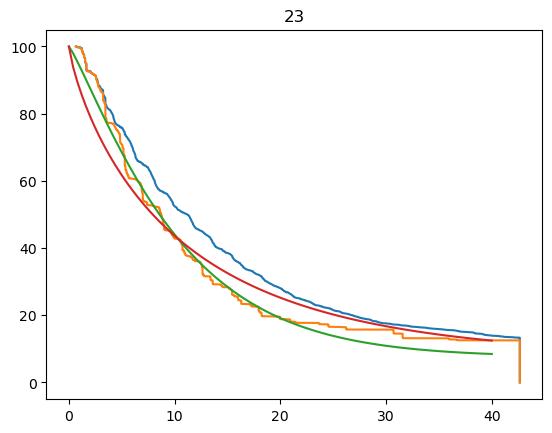

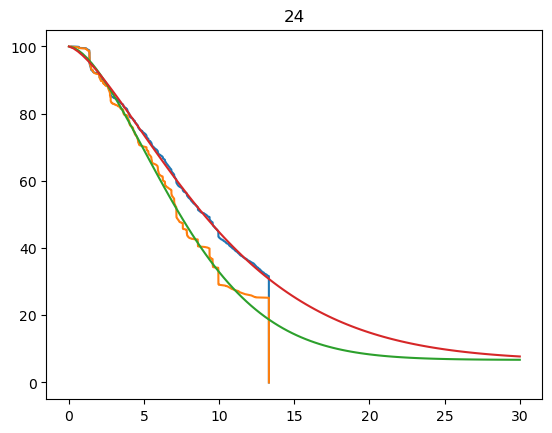

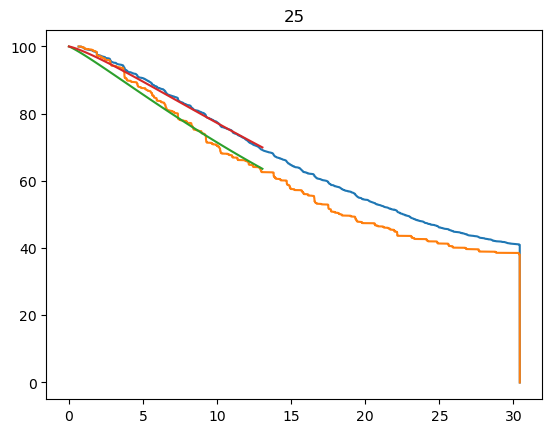

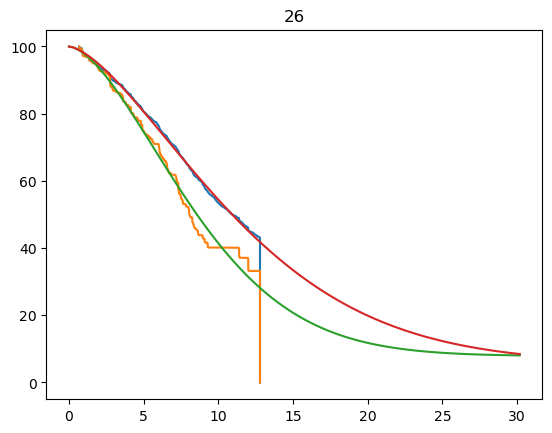

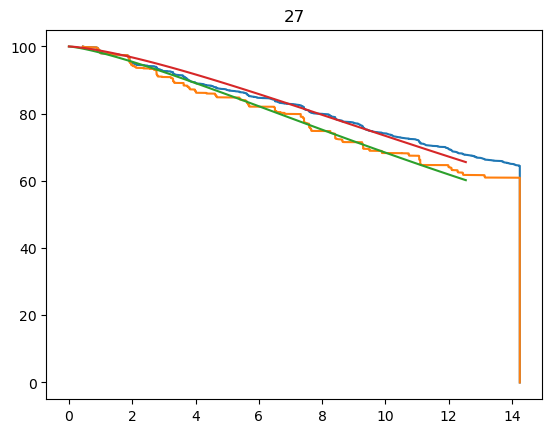

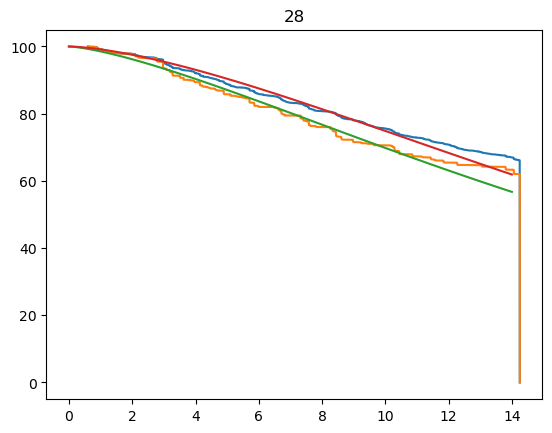

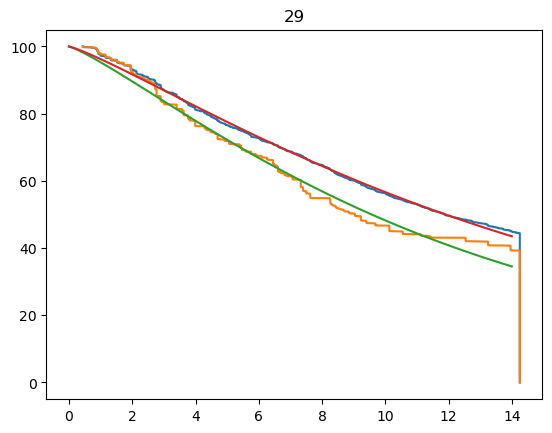

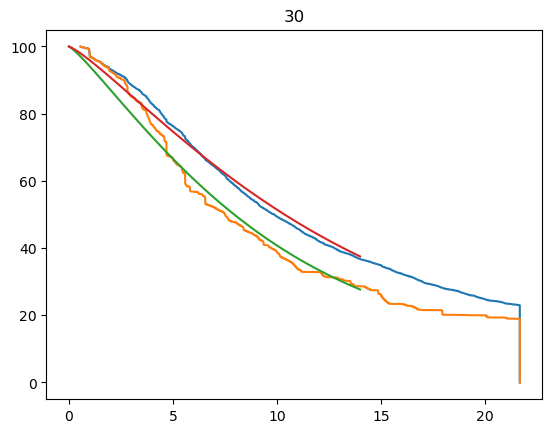

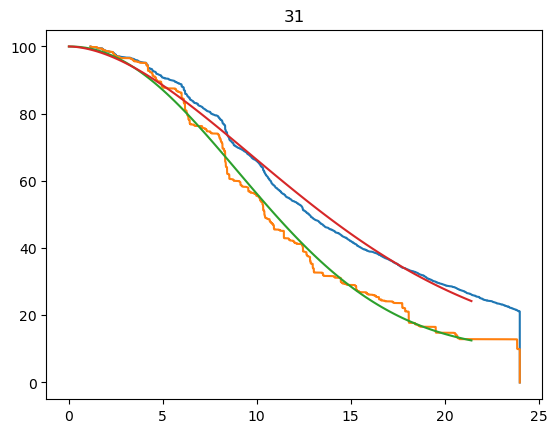

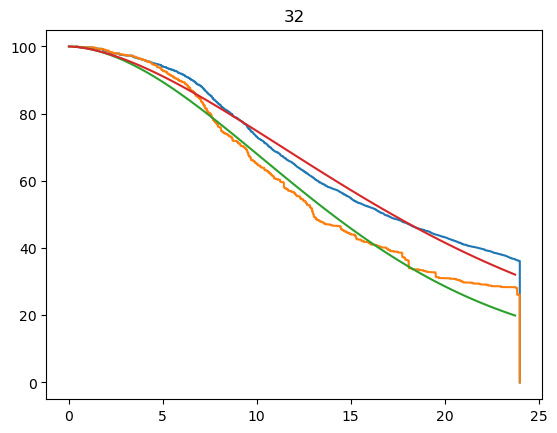

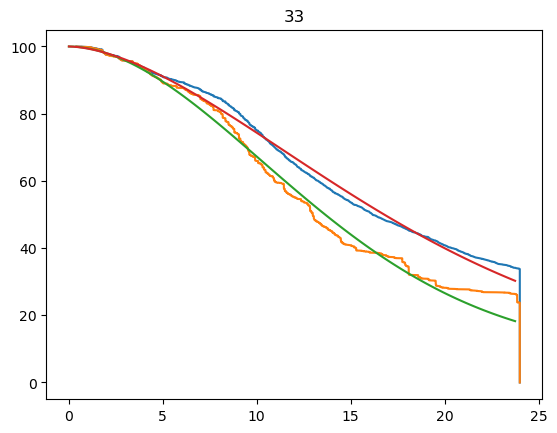

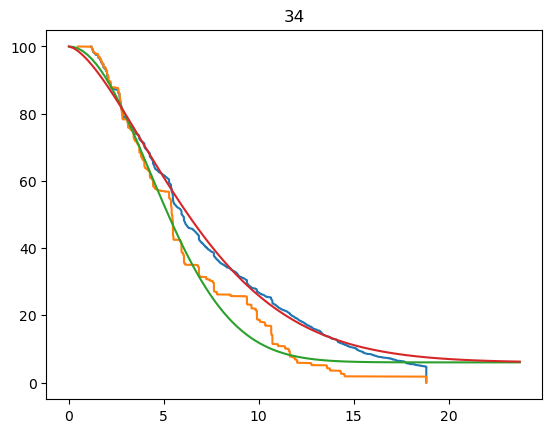

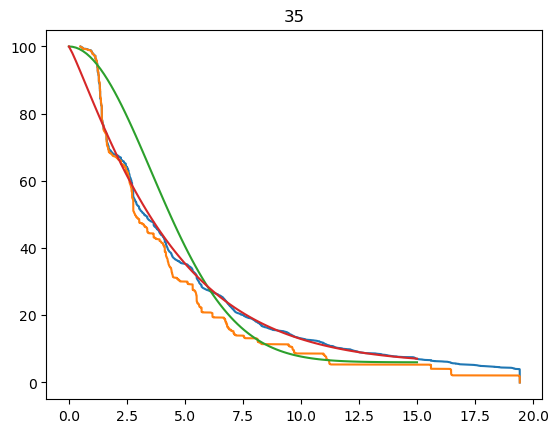

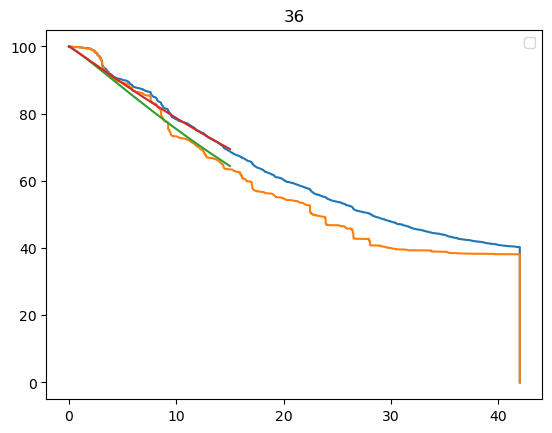

In [14]:
# calculate likelihood
tmp = df
tstep = 0.25
for i in range(tmp.shape[0]):
#for i in [22]:
    name_a = tmp.at[i, 'Experimental']
    name_b = tmp.at[i, 'Control']
    name_ab = tmp.at[i, 'Combination']
    n_combo = tmp.at[i, 'N_combination']
    lik_df.at[i, 'Name'] = name_ab
    #print(i, n_combo)
    # observed data
    df_ab = pd.read_csv(f'{COMBO_DATA_DIR}/{name_ab}.clean.csv').dropna()
    try:
        ipd_ab = pd.read_csv(f'{RAW_COMBO_DATA_DIR}/{name_ab}_indiv.csv')
        #print("used IPD")
    except FileNotFoundError:
        ipd_ab = create_ipd(df_ab, n=n_combo)
    

    # import prediction
    independent = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_ind.csv').dropna()
    additive = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_add.csv').dropna()
    models = [independent, additive]
    print(i, name_ab)

    t = np.linspace(0, tmax, 100)
    fig, ax = plt.subplots()
    ax.plot(additive['Time'], additive['Survival'])
    ax.plot(independent['Time'], independent['Survival'])
    ax.set_title(i)
    for k in range(len(models)):
        model = models[k]
        tmax = tmax_dict.get(i)
        if tmax is None:
            tmax = model['Time'].max() - tstep
        t_event = ipd_ab[ipd_ab['Event'] == 1]['Time'].values
        t_censor = ipd_ab[ipd_ab['Event'] == 0]['Time'].values
        wa, wb, wc = weibull3_params_from_digitized(model, tmax)
        ax.plot(t, weibull_survival(t, wa, wb, wc) * 100)
        l_event = weibull_pdf(t_event, wa, wb, wc)
        l_censor = weibull_survival(t_censor, wa, wb, wc)
        l_all = np.hstack((l_event, l_censor))
        #plt.plot(t_event, l_event, label=k)
        #plt.plot(t_censor, l_censor, label=k)
        neg_log_lik = np.round(np.sum(-np.log(l_all)), 3)
        if k == 0:
            lik_df.at[i, 'HSA_NLL'] = neg_log_lik
        elif k == 1:
            lik_df.at[i, 'Add_NLL'] = neg_log_lik

        #plt.vlines(t_event, ymin=0, ymax=100)
        #plt.vlines(t_censor, ymin=0, ymax=100)

plt.legend()

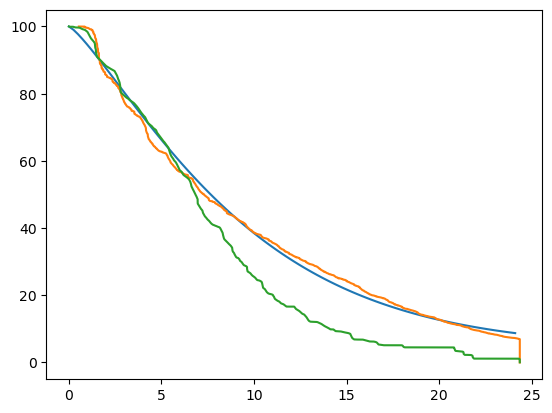

In [20]:
t = np.linspace(0, tmax, 100)
s = weibull_survival(t, wa, wb, wc)
plt.plot(t, s * 100, label='weibull')
plt.plot(additive['Time'], additive['Survival'])
plt.plot(df_ab['Time'], df_ab['Survival'])

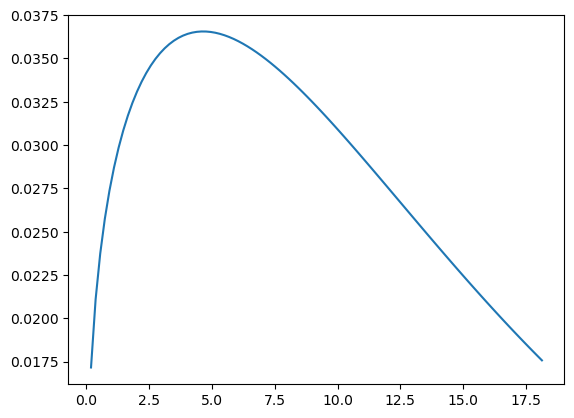

In [55]:
plt.plot(t, weibull_pdf(t, wa, wb, wc))

In [15]:
lik_df

Name  HSA_NLL  Add_NLL
0       Breast_Abemaciclib-Fulvestrant_Sledge2017_PFS  728.451  669.136
1   Breast_Abemaciclib-LetrozoleOrAnastrozole_John...  520.664  469.234
2   Breast_Capecitabine-Docetaxel_OShaughnessy2002...  640.455  584.986
3        Breast_Everolimus-Exemestane_Baselga2012_PFS  491.055  449.232
4      Breast_Ixabepilone-Capecitabine_Thomas2007_PFS  1081.59  1024.76
5       Breast_Lapatinib-Capecitabine_Kaufman2008_PFS  645.008  581.049
6   Breast_Palbociclib-Fulvestrant_Cristofanilli20...  390.011  364.366
7           Breast_Palbociclib-Letrozole_Finn2016_PFS  748.173  690.551
8   Breast_Pembrolizumab-Chemotherapy_Cortes2020_P...  418.322  399.876
9      Breast_Trastuzumab-Chemotherapy_Slamon2001_PFS  389.937  368.937
10  Cervical_Bevacizumab-Paclitaxel+CisplatinOrTop...  549.834   507.57
11  Colorectal_Bevacizumab-Fluorouracil+Leucovorin...  800.309  742.573
12  Colorectal_Cetuximab-FOLFIRI_VanCutsem2015_PFS...  255.272  225.616
13  Colorectal_Irinotecan-Cetuximab_Cunningham2004...  486.852  460.157
14  Colorectal_ZivAflibercept-FOLFIRI_VanCutsem201...   962.91  939.196
15       Gastric_Ramucirumab-Paclitaxel_Wilke2014_PFS  706.025  739.934
16  HeadNeck_Cetuximab-Platinum+Fluorouracil_Vermo...  430.073  383.503
17   Leukemia_Obinutuzumab-Chlorambucil_Goede2014_PFS   1209.9  727.075
18  Lung_Atezolizumab-Bevacizumab+Paclitaxel+Carbo...  670.519  620.497
19  Lung_Atezolizumab-PaclitaxelProteinBound+Carbo...  930.684  855.553
20  Lung_Atezolizumab-Carboplatin+Etoposide_Horn20...  409.092  410.459
21         Lung_Gemcitabine-Cisplatin_Sandler2000_PFS  615.914  574.357
22       Melanoma_Nivolumab-Ipilimumab_Larkin2019_PFS  535.664  523.711
23        Melanoma_Trametinib-Dabrafenib_Long2017_PFS  550.744  547.204
24  Mesothelioma_PemetrexedDisodium-Cisplatin_Voge...  501.818  472.044
25  Myeloma_Carfilzomib-Lenalidomide+Dexamethasone...  1122.11  1071.02
26  Myeloma_Daratumumab-Bortezomib+Dexamethasone_P...  213.079  175.252
27  Myeloma_Daratumumab-Carfilzomib+Dexamethasone_...   354.61  342.144
28  Myeloma_Daratumumab-Lenalidomide+Dexamethasone...   234.35  218.858
29  Myeloma_Daratumumab-Pomalidomide+Dexamethasone...    244.7  219.951
30   Myeloma_Lenalidomide-Dexamethasone_Weber2007_TTP  452.271  408.788
31  Ovarian_Bevacizumab-Gemcitabine+Carboplatin_Ag...  503.006  465.949
32  Ovarian_Bevacizumab-Paclitaxel+Carboplatin_Bur...  1784.13  1665.11
33  Ovarian_Bevacizumab-Paclitaxel+Carboplatin_Col...  937.802  868.996
34  Ovarian_Bevacizumab-PaclitaxelOrTopotecan_Puja...  410.928  352.935
35  Pancreatic_IrinotecanLiposome-Fluorouracil+Leu...  252.789  216.273
36     Prostate_Flutamide-Leuprolide_Crawford1989_PFS  657.618  617.311

In [19]:
2  + 2 * lik_df[['HSA_NLL','Add_NLL']].mean()

HSA_NLL    1236.414270
Add_NLL    1134.657405
dtype: float64

In [21]:
np.exp((1134.657405 - 1236.414270)/2)


8.012674807544403e-23

In [18]:
np.exp((((2 + 2 * 566.328703) - (2 + 2 * 617.207135))/2))


8.012678813883253e-23

In [203]:
1 - spl(17.75)

0.37839999999999996

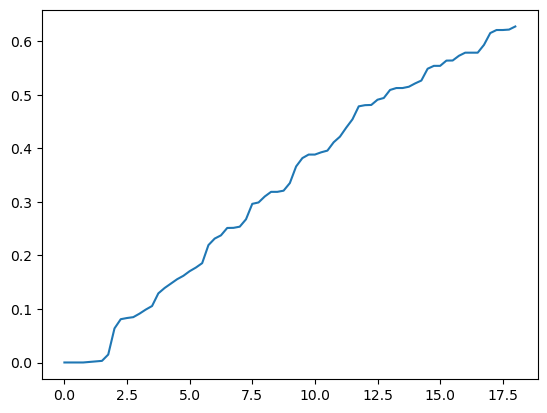

In [202]:
plt.plot(x, spl(x))

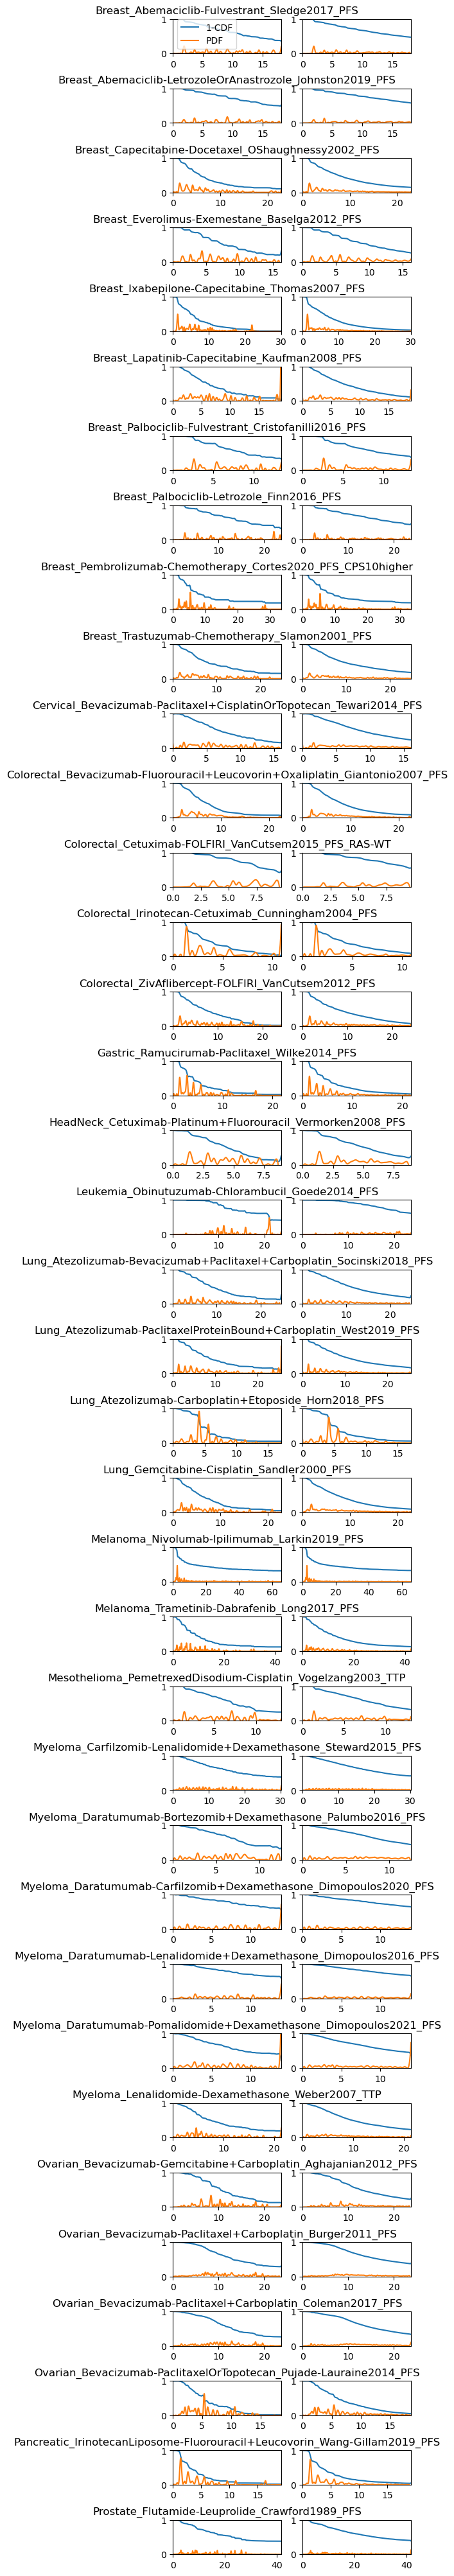

In [182]:
# Check if smoothing works
tstep = 0.25
babystep = 0.01
tmp = df
fig, axes = plt.subplots(tmp.shape[0], 2, figsize=(4, 40), constrained_layout=True)
for i in range(tmp.shape[0]):
    name_a = tmp.at[i, 'Experimental']
    name_b = tmp.at[i, 'Control']
    name_ab = tmp.at[i, 'Combination']
    n_combo = tmp.at[i, 'N_combination']
    # import prediction
    independent = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_ind.csv').dropna()
    additive = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_add.csv').dropna()
    models = [independent, additive]
    axes[i, 0].set_title(name_ab)
    for k in range(len(models)):
        model = models[k]
        tmax = model['Time'].max() - tstep
        f = interp1d(model['Time'], (100 - model['Survival'])/100, kind='zero', fill_value='extrapolate')
        x = np.arange(0, tmax, tstep)
        y = f(x)

        spl = make_interp_spline(x, y, k=5)
        more_x = np.arange(0, tmax, babystep)
        dydx = spl.derivative()
        axes[i, k].plot(more_x, 1 - spl(more_x), label='1-CDF')
        axes[i, k].plot(more_x, dydx(more_x), label='PDF')
        axes[i, k].set_xlim(0, tmax)
        axes[i, k].set_ylim(0, 1)

axes[0, 0].legend()
fig.savefig(f'{OUTDIR}/spline_sanity_check.pdf')


In [106]:
f_ind = interp1d(independent['Time'], (100 - independent['Survival'])/100, kind='zero', fill_value='extrapolate')
tstep = 0.25
x = np.arange(0, independent['Time'].max() - tstep, tstep)
y = f_ind(x)

In [142]:
spl = splrep(x, y, k=5, s=0.0004)
more_x = np.arange(0, independent['Time'].max() - 0.01, 0.01)
more_y = splev(more_x, spl)
dydx = splev(more_x, spl, der=1)


In [173]:
spl = make_interp_spline(x, y, k=5)
more_x = np.arange(0, independent['Time'].max() - 0.01, 0.01)
dydx = spl.derivative()


In [174]:
dydx.integrate(10, 15)

array(0.166)

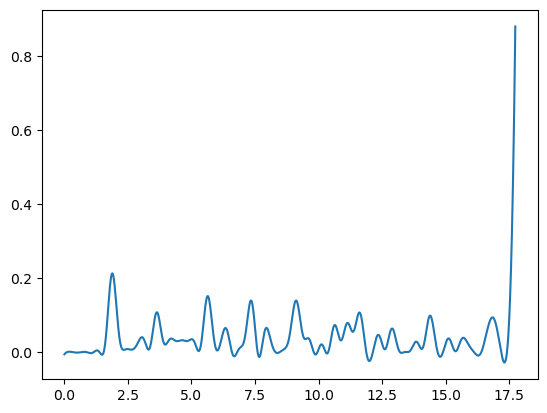

In [170]:
plt.plot(more_x, more_y(more_x))
#plt.ylim(0, 1)

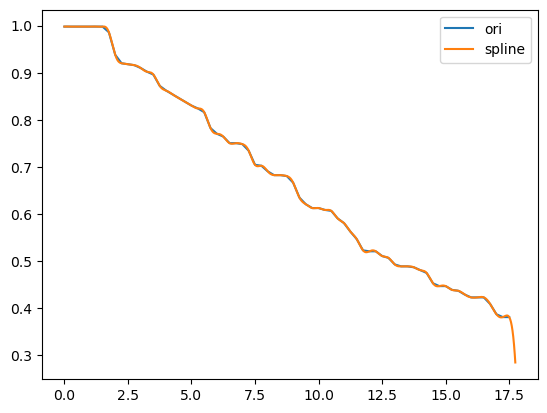

In [171]:
plt.plot(x, 1 - y, label='ori')
#plt.plot(more_x, 1 - more_y, label='spline')
plt.plot(more_x, 1 - spl(more_x), label='spline')

plt.legend()

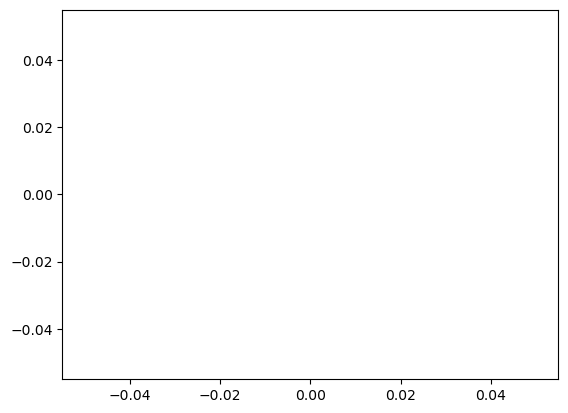

In [80]:
fig, ax = plt.subplots()
ax.plot(independent['Time'][::-1], y)
#ax.plot(independent['Time'][::-1], independent['Survival'][::-1])


In [66]:
def d_fun(fun, x):
    h = 1e-5
    return (fun(x+h)-fun(x-h))/(2*h)
